# Topic Models

First, let's get some data. We will use wine reviews. The text is already preprocessed (column `description_cleaned`), to save you some time.

In [1]:
import pandas as pd

In [2]:
import re
string = open('C:/Users/De/Downloads/Python Files/IM/IMTweetsForPython.csv', encoding='utf-8').read()
new_str = re.sub(r'\bs\b', ' ', string)
open('IMTweetsForPython1.csv', 'w', encoding='utf-8').write(new_str)

14015143

In [3]:
import re
string = open('C:/Users/De/Downloads/Python Files/IM/IMTweetsForPython1.csv', encoding='utf-8').read()
new_str = re.sub(r'\bt\b', ' ', string)
open('IMTweetsForPython2.csv', 'w', encoding='utf-8').write(new_str)

14015143

In [4]:
import re
string = open('C:/Users/De/Downloads/Python Files/IM/IMTweetsForPython2.csv', encoding='utf-8').read()
new_str = re.sub(r'\bm\b', ' ', string)
open('IMTweetsForPython2.csv', 'w', encoding='utf-8').write(new_str)

14015143

In [5]:
pip install langdetect

Note: you may need to restart the kernel to use updated packages.


In [6]:
df = pd.read_csv('C:/Users/De/Downloads/Python Files/IM/IMTweetsForPython2.csv')
len(df)

133091

In [22]:
 df.to_csv('test1.csv')

In [45]:
language_list = []

for text in df['Contents']:
	try:
		language = detect(text)
	except:
		language = 'unknown'
	language_list.append(language)

df['language'] = language_list

In [47]:
 df.to_csv('test.csv')

In [49]:
df = pd.read_csv('C:/Users/De/Downloads/Python Files/IM/OnlyEnglishIMTweets.csv')
len(df)

131603

In [50]:
df.head()

,SNO,Contents
0,0,we can change our gene expression. new researc...
1,1,add garlic to your diet. the compound allicin ...
2,2,baking low carb recipes with my mother via
3,3,weight not budging on the scale don forget e...
4,4,happy new year to each of you remember small s...


Here is how the data was cleaned

In [51]:
import spacy
nlp = spacy.load('en_core_web_sm')
def clean(text):
    return ' '.join([token.lemma_ # keep the base form
             for token in nlp(text) # after splitting the sentence into words
             if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X', 'PROPN'}]) # if the word is a content word

df['Contents_cleaned'] = df.Contents.apply(clean)

Before we start, let's remove any columns that have empty text fields and check whether the data type is correct.

In [52]:
# remove empty entries
df = df[df['Contents_cleaned'].notnull()]

# make sure everything is a string
df['Contents_cleaned'] = df['Contents_cleaned'].apply(str)

len(df)

131603

## LDA

Let's look at the most well-known probabilistic topic model, Latent Dicrichlet Allocation. `gensim` has a working implementation

In [53]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases

import time # to know how long training took
import multiprocessing # to speed things up by parallelizing

First, we create a corpus. We use collocations for frequent phrases, and filter out rare and overly frequent words (this will be one of our major parameters to influence the model).

In [54]:
limit=50000 # for speed reasons, let's only use 50k instances

# run on 50000 instances
instances = df['Contents_cleaned'].apply(str.split).tolist()[:limit]
print("creating dictionary", flush=True)
# read in instances and create Dictionary object w information about frequencies etc. 
phrases = Phrases(instances, min_count=5, threshold=1)
instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=50, no_above=0.3)
print(dictionary, flush=True)

creating dictionary
Dictionary(1385 unique tokens: ['change', 'exercise', 'gene', 'obesity', 'other']...)


Now, we can turn that corpus into a TFIDF-weighted data matrix. `gensim` uses its own logic and objects for that.

In [56]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


Let's visualize the different processing steps:

In [57]:
print(instances[0]) # original input
print()
print(ldacorpus[0]) # hashed BOW version
print()
print(model_corpus[0]) # TFIDF-weighted version

['change', 'gene', 'expression', 'new', 'research', 'show', 'jogging', 'other', 'exercise', 'ward', 'weight', 'gain', 'inherit', 'obesity', 'gene']

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (29, 1), (201, 1), (394, 1)]

[(0, 0.24279092196760269), (1, 0.2988452506060682), (2, 0.6740343438805052), (3, 0.34475383872317134), (4, 0.2552584828528529), (5, 0.2301014759307637), (29, 0.2547372977290396), (201, 0.148453625840051), (394, 0.27117047439263153)]


## Choosing the number of topics

To find the best number of topics, we run a `CoherenceModel` with different evaluation scores on a subset of the data.

In [58]:
coherence_values = []

dev_size = 50000

for num_topics in range(2, 20):
    model = LdaMulticore(corpus=model_corpus[:dev_size], 
                         id2word=dictionary, 
                         num_topics=num_topics, random_state=42)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances[:dev_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances[:dev_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

2 -3.892965932876641 0.22755909019680473
3 -3.8619387486653896 0.20038266621934522
4 -4.236743114055864 0.20921457189038514
5 -4.271712807383558 0.21669158169101013
6 -4.3030501625876925 0.20827132913162014
7 -4.663764730348385 0.23195187592423788
8 -4.484401707325949 0.2316252396449036
9 -4.563038040716027 0.24600258502613384
10 -4.777815736953975 0.2581475471406688
11 -4.74276447328003 0.24135944097349488
12 -4.755511266045083 0.233497146422926
13 -5.134599736385114 0.25582614088963085
14 -4.940987092158475 0.2508762500936794
15 -5.006014585969006 0.2664061730735196
16 -5.089182212913828 0.2408504547275162
17 -5.133786537842778 0.2477754896758888
18 -5.108686647332514 0.2661010930409413
19 -5.247549464194674 0.25656658867896737


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context('poster') # use large font


scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass'])
# scores['UMass'] = -scores['UMass']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,16));
#scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,16));


In [18]:
scores.corr()

,num_topics,UMass,CV
num_topics,1.000000,-0.478799,-0.587506
UMass,-0.478799,1.000000,0.812372
CV,-0.587506,0.812372,1.000000


Let's train a model on all (i.e., 50k) instances with the selected number of topics

In [59]:
num_topics = 15

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, # update after this many instances
                     alpha=0.5,
                     random_state=42
                    )
    
print("done in {}".format(time.time()-start), flush=True)


2500.0
fitting model
done in 69.748281955719


The result is a distribution over the topics for each document:

In [60]:
# transform the data into topic distros
topic_corpus = model[model_corpus]

topic_corpus[0]

[(0, 0.06078737),
 (1, 0.05386037),
 (2, 0.053178232),
 (3, 0.05252074),
 (4, 0.05704222),
 (5, 0.06981429),
 (6, 0.057489343),
 (7, 0.052685007),
 (8, 0.050992783),
 (9, 0.0575002),
 (10, 0.054305874),
 (11, 0.16733137),
 (12, 0.10293803),
 (13, 0.057773065),
 (14, 0.05178115)]

To get a description of the topics, we can use `print_topics()`

In [61]:
model.print_topics()

[(0,
  '0.020*"beauty" + 0.017*"old" + 0.014*"health" + 0.012*"doctor" + 0.012*"late" + 0.010*"year" + 0.010*"end" + 0.009*"man" + 0.009*"boost" + 0.008*"own"'),
 (1,
  '0.064*"review" + 0.017*"now" + 0.017*"new" + 0.015*"box" + 0.014*"gorgeous" + 0.014*"book" + 0.014*"discover" + 0.013*"blush" + 0.013*"right" + 0.012*"essential"'),
 (2,
  '0.044*"lip" + 0.022*"calendar" + 0.013*"recommendation" + 0.012*"pro" + 0.012*"hot" + 0.011*"fabulous" + 0.011*"now" + 0.011*"new" + 0.010*"way" + 0.009*"beauty"'),
 (3,
  '0.039*"come" + 0.033*"congrat" + 0.033*"name" + 0.029*"morning" + 0.023*"more" + 0.017*"just" + 0.016*"colour" + 0.015*"big" + 0.013*"day" + 0.012*"duo"'),
 (4,
  '0.023*"autumn" + 0.015*"wait" + 0.013*"cool" + 0.011*"review" + 0.010*"there" + 0.010*"vegan" + 0.008*"new" + 0.008*"update" + 0.008*"more" + 0.008*"health"'),
 (5,
  '0.043*"favourite" + 0.016*"recent" + 0.012*"fashion" + 0.012*"lifestyle" + 0.012*"fall" + 0.010*"really" + 0.009*"learn" + 0.009*"show" + 0.009*"episode

It's a bit inconvenient, let's clean it up with RegExes:

In [62]:
import re

# get the topic descriptions
topic_sep = re.compile("0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "beauty", "old", "health", "doctor", "late"
2 "review", "now", "new", "box", "gorgeous"
3 "lip", "calendar", "recommendation", "pro", "hot"
4 "come", "congrat", "name", "morning", "more"
5 "autumn", "wait", "cool", "review", "there"
6 "favourite", "recent", "fashion", "lifestyle", "fall"
7 "need", "powder", "health", "wonder", "way"
8 "christmas", "collection", "scent", "gift", "new"
9 "recipe", "healthy", "summer", "easy", "family"
10 "body", "love", "meat", "too", "woman"
11 "book", "happy", "foundation", "worth", "look"
12 "thank", "all", "egg", "get", "kit"
13 "most", "great", "daily", "sure", "article"
14 "hair", "have", "instagram", "sugar", "control"
15 "follow", "enter", "give", "rt", "today"


## Aggregating topics by a dependent variable

Here, we have various labels for each document. Rather than lookinf at each document by itself, let's aggregate them by `country`.

In [66]:
#target_category = 'country'

# get a list with the topic scores for each document
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(limit)]

# turn that into a data frame with N rows and K columns, 
# each with the score of the corresponding topic
topic_distros = pd.DataFrame(data=scores, columns=descriptors)

# add the review category of each document as column (so we can aggregate)
#topic_distros['category'] = df[target_category][:limit]

In [67]:
topic_distros.head()

,"beauty, old","review, now","lip, calendar","come, congrat","autumn, wait","favourite, recent","need, powder","christmas, collection","recipe, healthy","body, love","book, happy","thank, all","most, great","hair, have","follow, enter"
0,0.060768,0.053859,0.053178,0.052518,0.057037,0.069978,0.057476,0.052684,0.050992,0.057494,0.054304,0.167328,0.102839,0.057764,0.051780
1,0.054743,0.061912,0.090685,0.050493,0.062771,0.057984,0.070188,0.050219,0.052679,0.063093,0.053834,0.108288,0.088981,0.059529,0.074601
2,0.056655,0.054286,0.058850,0.054659,0.059349,0.056418,0.056248,0.054122,0.146130,0.056966,0.055331,0.095837,0.058067,0.084445,0.052636
3,0.058352,0.065117,0.052616,0.049505,0.059328,0.181362,0.056850,0.050306,0.055617,0.059519,0.066026,0.055056,0.085058,0.056331,0.048958
4,0.062929,0.060926,0.079825,0.056874,0.055058,0.054734,0.069918,0.058845,0.051290,0.053779,0.131989,0.053348,0.075478,0.080380,0.054627


In [68]:
 topic_distros.to_csv('lda_allocation.csv')

In [69]:
 topic_distros1= topic_distros.eq( topic_distros.max(axis=0),axis=1).astype(int)

In [70]:
topic_distros1.head()

,"beauty, old","review, now","lip, calendar","come, congrat","autumn, wait","favourite, recent","need, powder","christmas, collection","recipe, healthy","body, love","book, happy","thank, all","most, great","hair, have","follow, enter"
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [71]:
 topic_distros1.to_csv('lda_allocation_dummies.csv')

We can now aggregate and visualiz the results: what is the topic distribution for each country (based on the documents from that country)?

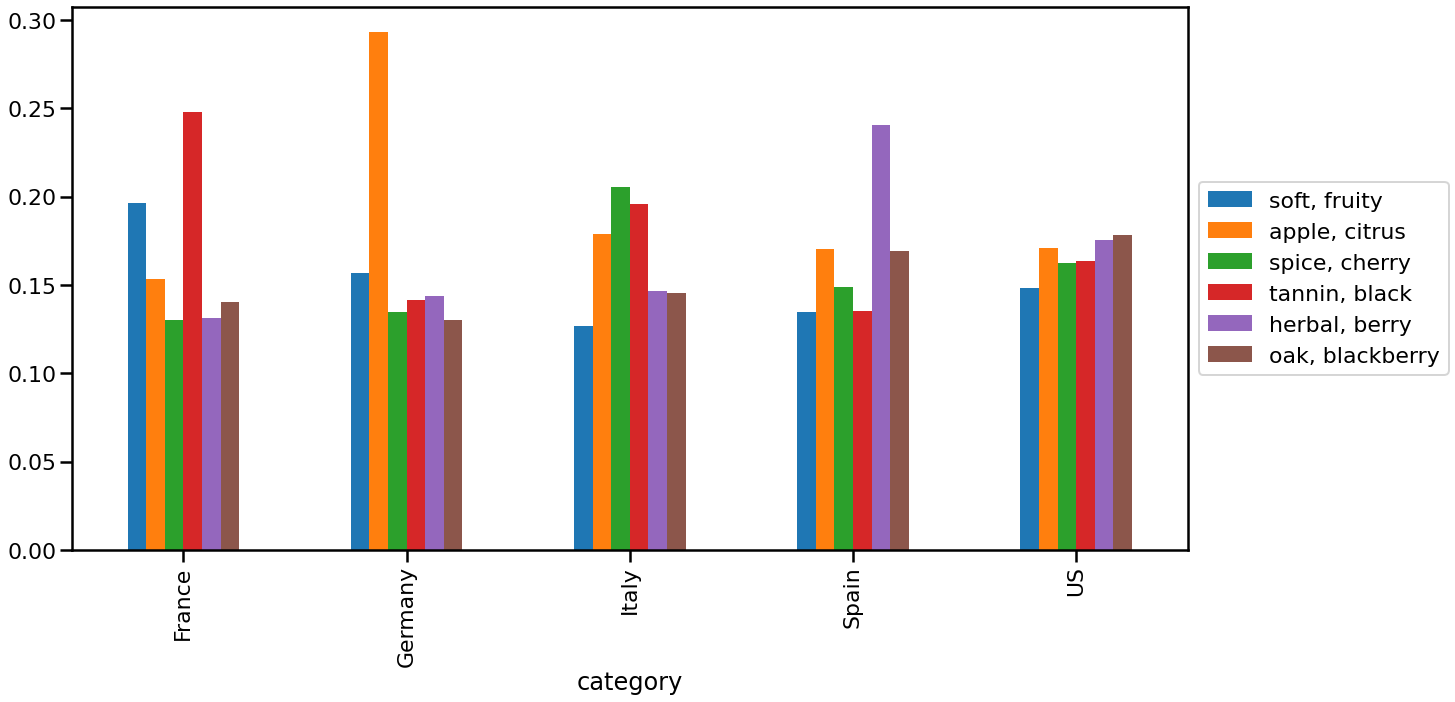

In [25]:
seaborn.set_context('poster') # use large font
fig, ax = plt.subplots(figsize=(20, 10)) # set graph size

# aggregate topics by categories
aggregate_by_category = topic_distros[topic_distros.category.isin('Germany US Italy France Spain'.split())]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()

# plot the graph
aggregate_by_category[descriptors].plot.bar(ax=ax);

# move the legend out
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

# Author Topic Model

You might have noticed that every country has at least 10% of every topic. That is an effect of the averaging over many documents. 

Instead of aggregating after fitting the model, we could already learn different topic distributions for each country *while training the model*. This is an Author Topic Model (the authors are just categories, in our case the country).

In [30]:
from gensim.models import AuthorTopicModel
from gensim.test.utils import datapath, temporary_file

The syntax is almost the same, but we have to provide a mapping from each country to the associated documents.

In [26]:
from collections import defaultdict
author2doc = defaultdict(list) # mapping from country to document

for i, country in enumerate(df[target_category][:limit]):
    author2doc[country].append(i)
    
len(author2doc)

42

In [28]:
print(author2doc['US'])

[0, 2, 3, 8, 9, 11, 12, 14, 15, 16, 19, 20, 23, 24, 26, 27, 28, 29, 31, 34, 42, 47, 49, 54, 55, 57, 58, 65, 67, 68, 69, 70, 71, 73, 75, 77, 78, 80, 87, 88, 89, 90, 93, 96, 97, 100, 101, 103, 104, 105, 106, 107, 108, 109, 112, 113, 120, 121, 122, 123, 124, 125, 126, 127, 131, 132, 133, 134, 135, 136, 137, 141, 142, 143, 144, 145, 146, 148, 149, 150, 157, 160, 161, 163, 164, 165, 169, 170, 173, 178, 180, 181, 182, 183, 185, 186, 187, 196, 197, 198, 199, 200, 201, 204, 205, 206, 207, 208, 212, 220, 221, 223, 226, 227, 228, 230, 231, 232, 233, 245, 246, 248, 249, 250, 252, 253, 254, 256, 257, 262, 263, 266, 267, 268, 272, 273, 274, 275, 279, 284, 285, 289, 292, 293, 295, 298, 299, 300, 301, 303, 304, 306, 307, 308, 309, 310, 313, 314, 315, 316, 317, 319, 324, 329, 332, 334, 336, 337, 338, 341, 343, 346, 347, 350, 351, 354, 356, 357, 360, 361, 362, 365, 371, 372, 376, 379, 380, 381, 382, 386, 387, 388, 389, 390, 391, 393, 403, 406, 407, 408, 409, 413, 414, 415, 416, 420, 421, 422, 423, 426,

Again, we select the best number of topics on a subset. Note that the only difference in syntax is the mapping we provide. We also use the raw count corpus instead of the TFIDF version, as the Author Topic Model seems insensitive to the small numbers of TFDIF.

In [38]:
coherence_values = []
author_model_list = []

dev_size = 15000

dev_author2doc = {key: [idx for idx in value if idx < dev_size] for key, value in author2doc.items()}

for num_topics in range(5, 11):
    author_model = AuthorTopicModel(corpus=list(ldacorpus[:dev_size]), 
                                    author2doc=dev_author2doc, # the only difference to LDA 
                                    id2word=dictionary, 
                                    num_topics=num_topics,
                                    alpha=0.5,
                                    random_state=42
                                   )
    
    coherencemodel_umass = CoherenceModel(model=author_model, 
                                          texts=instances[:dev_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=author_model, 
                                       texts=instances[:dev_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

5 -1.9815951039453357 0.3505214309274196
6 -2.0358930741973054 0.3702907956987406
7 -2.007539789953755 0.3761344387114817
8 -2.0402896044973833 0.3919183632807848
9 -3.6681755562985776 0.40371977934347497
10 -3.2899826752744614 0.3776047162562098


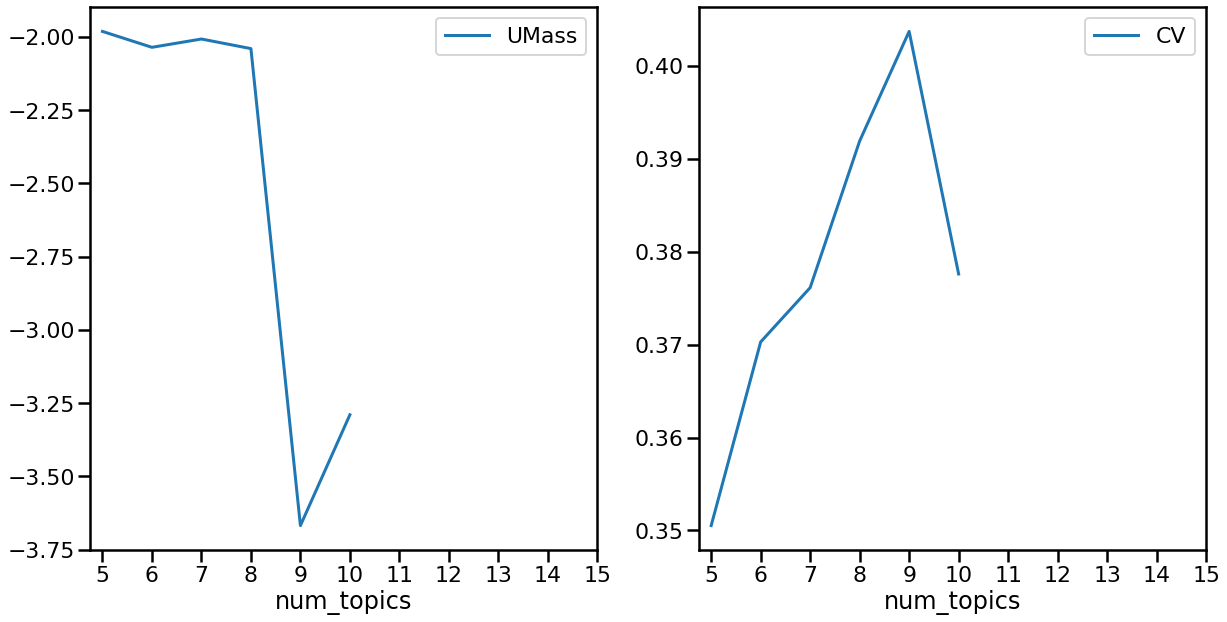

In [39]:
%matplotlib inline
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,16));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,16));

In [40]:
# train model with best number of topics
n_topics_author = 6

author_model = AuthorTopicModel(corpus=list(ldacorpus), 
                                author2doc=author2doc, 
                                id2word=dictionary, 
                                num_topics=n_topics_author,
                                passes=num_passes,
                                chunksize=chunk_size,
                                alpha=0.5,
                                random_state=42
)


Again, we change the topic presentations to be more readable

In [42]:
# extract a list of tuples with topic number and descriptors from the model
author_model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                author_model.print_topics(num_topics=n_topics_author, num_words=5)]

author_descriptors = []
for i, m in sorted(author_model_topics):
    print(i+1, ", ".join(m[:5]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "cherry", "fruit", "dry", "tannin", "oak"
2 "finish", "note", "palate", "apple", "dry"
3 "fruit", "spice", "aroma", "that", "bright"
4 "black", "palate", "aroma", "cherry", "offer"
5 "finish", "aroma", "palate", "berry", "fruit"
6 "fruit", "acidity", "have", "tannin", "ripe"


We now set up a mapping from each country to the topic distributions. `gensim` uses a sparse representation, so to make visualization easier, we turn it into a dense lookup

In [45]:
# initialize mapping from covariate(=author/country) to topic distro, set all to 0.0
author_vecs = {author: {author_descriptors[t]: 0.0
                         for t in range(author_model.num_topics)}
              for author in author_model.id2author.values()
              }
# update mappings from model
for author in author_model.id2author.values():
    for (t, v) in author_model.get_author_topics(author):
        author_vecs[author][author_descriptors[t]] = v

        
target_countries = 'Germany US Italy France Spain'.split()
for country in target_countries:
    print(country, author_vecs[country])        

Germany {'cherry, fruit': 0.1235583893283326, 'finish, note': 0.7312541122702656, 'fruit, spice': 0.06551560271883741, 'black, palate': 0.0, 'finish, aroma': 0.05509750030011989, 'fruit, acidity': 0.023930901423231704}
US {'cherry, fruit': 0.5015605718617913, 'finish, note': 0.2559298153553883, 'fruit, spice': 0.06411291204956104, 'black, palate': 0.0, 'finish, aroma': 0.10861476649655513, 'fruit, acidity': 0.06891712935821166}
Italy {'cherry, fruit': 0.02199191417491066, 'finish, note': 0.0746838231573395, 'fruit, spice': 0.7067540229047486, 'black, palate': 0.18478357706507959, 'finish, aroma': 0.0, 'fruit, acidity': 0.0}
France {'cherry, fruit': 0.07269889169167162, 'finish, note': 0.13584778710693643, 'fruit, spice': 0.05367813395168086, 'black, palate': 0.044180300297245755, 'finish, aroma': 0.03664986799770145, 'fruit, acidity': 0.6569450189547639}
Spain {'cherry, fruit': 0.07153450744087839, 'finish, note': 0.1176461618798966, 'fruit, spice': 0.05787983766087592, 'black, palate'

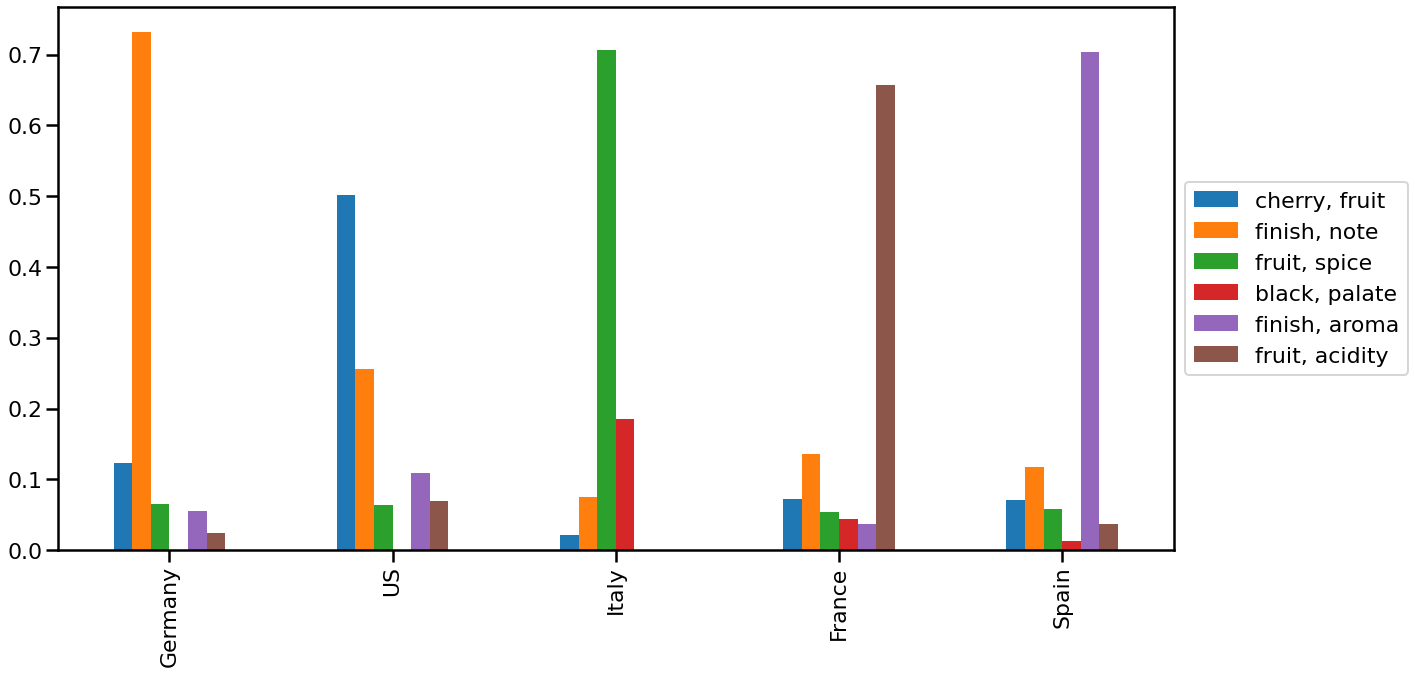

In [46]:
# make a DataFrame
author_df = pd.DataFrame.from_dict(author_vecs)

# plot it
fig, ax = plt.subplots(figsize=(20,10))
author_df[target_countries].T.plot.bar(ax=ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

Note how the dominant topic is much higher than before, whereas the secondary topics have much lower probability.